# AAI 628 Final Project
## Deep Learning Dog vs. Cat Classifier - VGG16
### Tim Demetriades
December 16th, 2021

Here we continue from the previous notebook. Since we want to use **transfer learning** to create a model based on a **VGG16 model** that was trained on the **ImageNet dataset**, we switched to Google Colab to take advantage of the **GPU** runtime.

First we import the needed modules.

In [ ]:
import os
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from PIL import Image

These are the paths where the training and test zip files are located.

In [ ]:
train_zip = r"drive/MyDrive/Dogs-Cats-Pics/dogs-vs-cats/train.zip"
test_zip = r"drive/MyDrive/Dogs-Cats-Pics/dogs-vs-cats/test1.zip"

Below we unzip the train and test files to the working directory.

In [ ]:
if not os.path.exists('train'):
    with zipfile.ZipFile(train_zip, 'r') as z:
        z.extractall('.')
if not os.path.exists('test'):
    with zipfile.ZipFile(test_zip, 'r') as z:
        z.extractall('.')

Here we grab the filenames and the labels from the filenames. Since each file is in the form 'cat.123.jpg' or 'dog.123.jpg', we can split on the '.' to grab either 'cat' or 'dog'. We can then assign a 0 to 'cat' and a 1 to 'dog'.

For the test images we just grab the filenames.

In [ ]:
train_folder = r"train"
filenames = os.listdir(train_folder)
test_folder = r"test1"
filenames_test = os.listdir(test_folder)

labels = []
for file in filenames:
    label = file.split('.')[0]
    if label == 'cat':
        labels.append(0)    # 0 = cat
    else:
        labels.append(1)    # 1 = dog 

A Pandas dataframe is created of the filenames and their labels (either 0 or 1) for the train data.

Another dataframe is created of just the filenames for the test data.

In [ ]:
train_df = pd.DataFrame({'filename': filenames, 'label': labels})

In [ ]:
train_df

filename  label
0       dog.9554.jpg      1
1      cat.11794.jpg      0
2       dog.9907.jpg      1
3       cat.6723.jpg      0
4       cat.9000.jpg      0
...              ...    ...
24995  dog.11702.jpg      1
24996   cat.9079.jpg      0
24997   cat.4762.jpg      0
24998  dog.10998.jpg      1
24999   cat.6293.jpg      0

[25000 rows x 2 columns]

In [ ]:
test_df = pd.DataFrame({'filename': filenames_test})
test_df

filename
0       1844.jpg
1       5893.jpg
2       5478.jpg
3       9977.jpg
4       3467.jpg
...          ...
12495   5812.jpg
12496   6473.jpg
12497   2457.jpg
12498   2538.jpg
12499  12012.jpg

[12500 rows x 1 columns]

Here some constants are defined.

In [ ]:
IMAGE_SIZE = 100
IMAGE_CHANNELS = 3

We will use **generators** this time instead of loading the entire dataset to variables. This should help improve performance and also allows us to add **data augmentation**.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [ ]:
train_df['label'] = train_df['label'].astype('string')    # flow_from_dataframe binary class_mode expects string

Here we split the training data into training data and validation data so that we can create a **train generator** and a **validation generator**.

In [ ]:
train_split_df, validate_split_df = train_test_split(train_df, test_size = 0.2, random_state = 25)
print(train_split_df.shape)
print(validate_split_df.shape)

(20000, 2)
(5000, 2)


We create the generators. For the training generator we add several data augmentations to add more data and try to improve the model.

In [ ]:
train_data_gen = ImageDataGenerator(rescale = 1 / 255, 
                                    rotation_range = 40, 
                                    width_shift_range = 0.2, 
                                    height_shift_range = 0.2, 
                                    shear_range = 0.2, 
                                    zoom_range = 0.2, 
                                    horizontal_flip = True)
validate_data_gen = ImageDataGenerator(rescale = 1 / 255)
test_data_gen = ImageDataGenerator(rescale = 1 / 255)

In [ ]:
train_generator = train_data_gen.flow_from_dataframe(train_split_df, 
                                                     train_folder,
                                                     x_col = 'filename',
                                                     y_col = 'label',
                                                     target_size = (IMAGE_SIZE, IMAGE_SIZE), 
                                                     batch_size = 20, 
                                                     class_mode = 'binary')

Found 20000 validated image filenames belonging to 2 classes.


In [ ]:
validate_generator = validate_data_gen.flow_from_dataframe(validate_split_df,
                                                           train_folder,
                                                           x_col = 'filename',
                                                           y_col = 'label',
                                                           target_size = (IMAGE_SIZE, IMAGE_SIZE), 
                                                           batch_size = 20, 
                                                           class_mode = 'binary')

Found 5000 validated image filenames belonging to 2 classes.


In [ ]:
test_generator = test_data_gen.flow_from_dataframe(test_df,
                                                   test_folder,
                                                   x_col = 'filename',
                                                   y_col = None,
                                                   target_size = (IMAGE_SIZE, IMAGE_SIZE), 
                                                   batch_size = 20, 
                                                   class_mode = None,
                                                   shuffle = False)

Found 12500 validated image filenames.


In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16

Here we create the **base model**, which is the VGG16 model minus the top 3 fully connected layers (so just the 13 convolution layers).

In [ ]:
conv_base = VGG16(weights = 'imagenet', 
                  include_top = False, 
                  input_shape = (IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

Here you can see there are **significantly more total parameters** compared to the previous model (**14.7 million vs 3.4 million**). We do not want to train all of these parameters so we will **freeze them** and then just **build 3 new fully connected layers** to train for our model.

In [ ]:
conv_base.trainable = False

model_vgg16 = Sequential()

model_vgg16.add(conv_base)

model_vgg16.add(Flatten())

model_vgg16.add(Dense(512, activation = 'relu'))
model_vgg16.add(Dense(128, activation = 'relu'))
model_vgg16.add(Dense(2, activation = 'softmax'))

In [ ]:
model_vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 512)               2359808   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 17,140,418
Trainable params: 2,425,730
Non-trainable params: 14,714,688
_________________________________________________________________


Let's create **checkpoint and early** objects like we did for the previous model so that we can have our model save as it trains and also stop training if the validation accuracy stop improving.

In [ ]:
checkpoint_vgg16 = ModelCheckpoint(filepath = 'model_vgg16.h5', 
                             monitor = 'accuracy', 
                             verbose = 0, 
                             save_best_only = True, 
                             save_freq = 5)
early_vgg16 = EarlyStopping(monitor = 'val_accuracy', patience = 8, verbose = 1)

Finally we train the new model.

In [ ]:
model_vgg16.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history_vgg16 = model_vgg16.fit(train_generator, 
                                epochs = 25, 
                                validation_data = validate_generator, 
                                validation_steps = 50, 
                                callbacks = [checkpoint_vgg16, early_vgg16])

Epoch 1/25
1000/1000 [==============================] - 250s 244ms/step - loss: 0.4553 - accuracy: 0.7829 - val_loss: 0.3344 - val_accuracy: 0.8570
Epoch 2/25
1000/1000 [==============================] - 140s 140ms/step - loss: 0.4014 - accuracy: 0.8145 - val_loss: 0.3181 - val_accuracy: 0.8490
Epoch 3/25
1000/1000 [==============================] - 137s 137ms/step - loss: 0.3849 - accuracy: 0.8231 - val_loss: 0.3259 - val_accuracy: 0.8560
Epoch 4/25
1000/1000 [==============================] - 137s 137ms/step - loss: 0.3775 - accuracy: 0.8273 - val_loss: 0.2863 - val_accuracy: 0.8850
Epoch 5/25
1000/1000 [==============================] - 136s 136ms/step - loss: 0.3752 - accuracy: 0.8281 - val_loss: 0.2827 - val_accuracy: 0.8810
Epoch 6/25
1000/1000 [==============================] - 136s 136ms/step - loss: 0.3643 - accuracy: 0.8335 - val_loss: 0.2896 - val_accuracy: 0.8710
Epoch 7/25
1000/1000 [==============================] - 136s 136ms/step - loss: 0.3656 - accuracy: 0.8321 - val_

Above we can see the results of the training. The model only trained for **15 epochs** as a results of **early stopping** (8 consecutive epochs of no improvement in the valiation accuracy). We can see that the training loss steadily decreased and the training accuracy steadily increased as expected. More importantly, the validation loss decreased over time for the most part and the validation accuracy increased for the most part, although still with some fluctuations but significantly less than with the other model.

This model achieved a **training accuracy** of **85%** and **validation accuracy** of around **89%**.

Below are two plots, one for the loss and another for the accuracy.

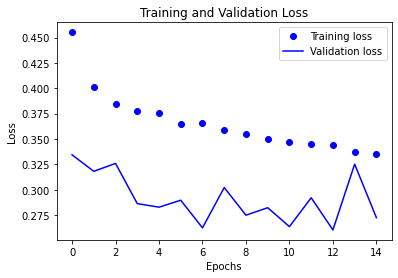

In [ ]:
# Plot loss
loss_values = history_vgg16.history['loss']
val_loss_values = history_vgg16.history['val_loss']
plt.plot(loss_values, 'bo', label='Training loss')
plt.plot(val_loss_values, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

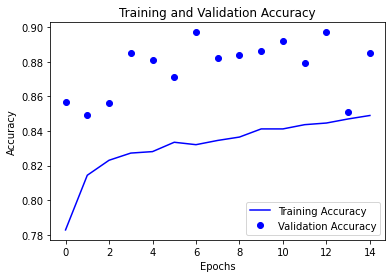

In [ ]:
# Plot Accuracy
acc_values = history_vgg16.history['accuracy']
val_acc_values = history_vgg16.history['val_accuracy']
plt.plot(acc_values, 'b', label='Training Accuracy')
plt.plot(val_acc_values, 'bo', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The plots above show something interesting - the validation loss was actually **lower** than the training loss and the validation accuracy was higher than the training accuracy. This is usually a sign of **underfitting**, the opposite of overfitting, in which there is **high bias but low variance**. Since the model has both dropout and data augmentation, it makes sense for this to occur since the model will have a harder time being accurate on the training data (which is of course intentionally as we want the model to be more **robust**). 

Let's now do the same as with the other model and make **predictions**.

In [ ]:
predictions = model_vgg16.predict(test_generator, verbose = 1)

625/625 [==============================] - 51s 81ms/step


In [ ]:
np.argmax(predictions, axis = 1)

array([0, 1, 1, ..., 1, 1, 1])

In [ ]:
test_df['label'] = np.argmax(predictions, axis = 1)

In [ ]:
test_df

filename  label
0       1844.jpg      0
1       5893.jpg      1
2       5478.jpg      1
3       9977.jpg      0
4       3467.jpg      1
...          ...    ...
12495   5812.jpg      1
12496   6473.jpg      1
12497   2457.jpg      1
12498   2538.jpg      1
12499  12012.jpg      1

[12500 rows x 2 columns]

Here we test the predictions by randomly taking a **sample of 9 test images** and showing what the model predicted them as.

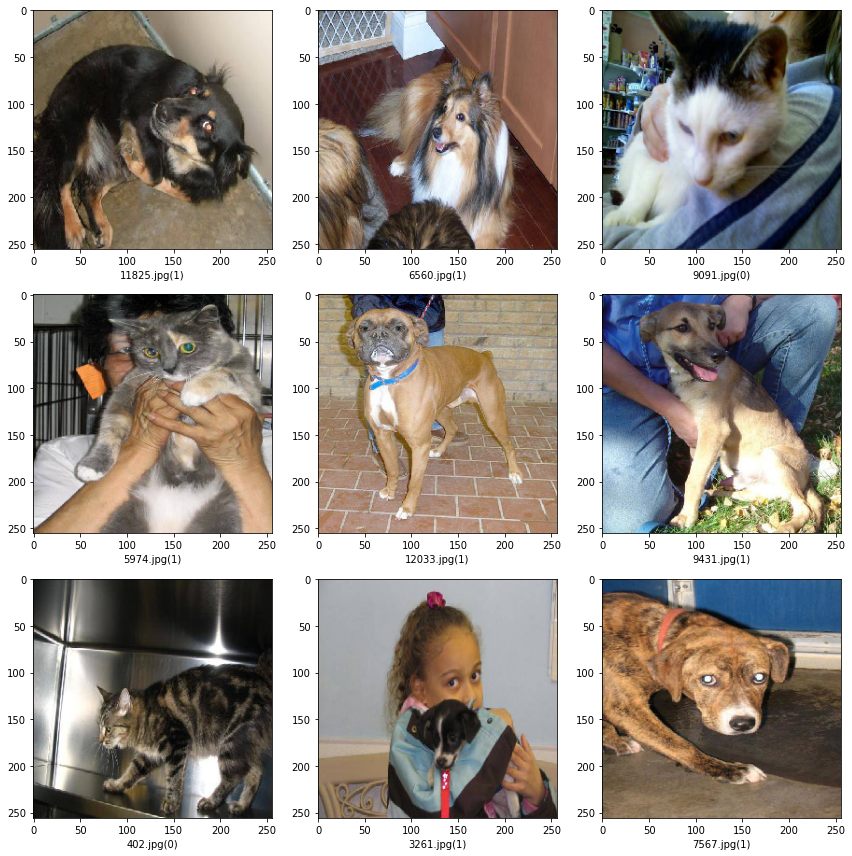

In [ ]:
sample_test = test_df.sample(n=9).reset_index()    # grab 9 random rows from the df
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    label = row['label']
    image = load_img("test1/"+filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(image)                                        # display the image
    plt.xlabel(filename + '(' + "{}".format(label) + ')')    # display the filename and prediction
plt.tight_layout()
plt.show()

The model did pretty well, correctly classifying **8 of the 9 images** (89%). This makes sense as the model had a validation accuracy of around **89%**.

Finally we save the results to a csv file.

In [ ]:
results_df = test_df.copy()
results_df['id'] = results_df['filename'].str.split('.').str[0]
results_df.drop(['filename'], axis = 1, inplace = True)
results_df = results_df[['id', 'label']]   # make sure this is the order
results_df.to_csv('results_vgg16.csv', index = False) 

In [ ]:
results_df.head()

id  label
0  1844      0
1  5893      1
2  5478      1
3  9977      0
4  3467      1

Overall we created 2 models, a **simple CNN** and then a **VGG16 model** created with transfer learning. Both models performed pretty well, with the VGG16 model performing better. This makes sense as it is a much deeper model trained on a much larger dataset. All in all, both models were able to do a respectable job of classifying the images, obtaining **accuracies around 85 - 90%**.